In [94]:
!pip install wfdb matplotlib numpy scipy

Libraries

In [95]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

Load ECG Data

Summary Table of Diseased ECG Records (MIT-BIH Arrhythmia Database)
You can use these record numbers to load ECG data with arrhythmias for testing.

 | Record | Disease Example           |
 |--------|--------------------------|
 | 201    | Atrial Fibrillation      |
 | 203    | Atrial Fibrillation      |
 | 207    | Ventricular Tachycardia  |
 | 208    | Ventricular Tachycardia  |
 | 209    | Ventricular Tachycardia  |
 | 214    | Ventricular Tachycardia  |
 | 232    | Ventricular Tachycardia  |Atrial Fibrillation
 | 233    | Ventricular Tachycardia  |


Loaded record '232' with 360 Hz sampling


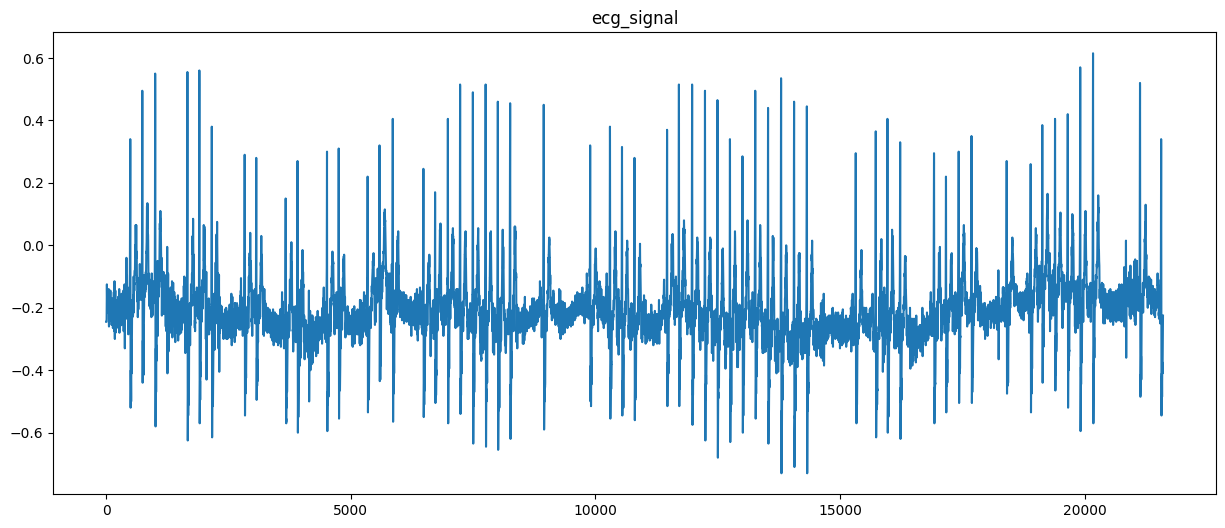

In [96]:
record_name = '100'  # nornaml
# # record_name = '203' #Atrial Fibrillationia
# record_name = '232'  # Atrial Fibrillation
# # record_name = '207'

# try:
#     record = wfdb.rdrecord(record_name)
#     ecg_signal = record.p_signal[:, 0]
#     # fs = record.fs  # Sampling frequen

#     fs = 360
#     samp_sec = 120  # Number of seconds to plotds to plot
#     # num_samples = int(120 * fs)  # Number of samples in 120 seconds
#     num_samples = int(samp_sec * fs)
#     ecg_signal = ecg_signal[:num_samples]
#     print(f"Loaded record '{record_name}' with sampling rate {fs} Hz")
# except FileNotFoundError:
#     print(f"Error: Record '{record_name}' not found. Check PhysioNet access.")

record_name = '232'  # Ventricular Tachycardia example
fs = 360  # MIT-BIH sampling frequency
samp_sec = 60  # Analysis duration

try:
    record = wfdb.rdrecord(record_name)
    ecg_signal = record.p_signal[:, 0][:int(samp_sec*fs)]
    print(f"Loaded record '{record_name}' with {fs} Hz sampling")
except Exception as e:
    print(f"Error: {str(e)}")

plt.figure(figsize=(15, 6))    
plt.plot(ecg_signal)
plt.title("ecg_signal")
plt.show()
    

Amplitude Normalization

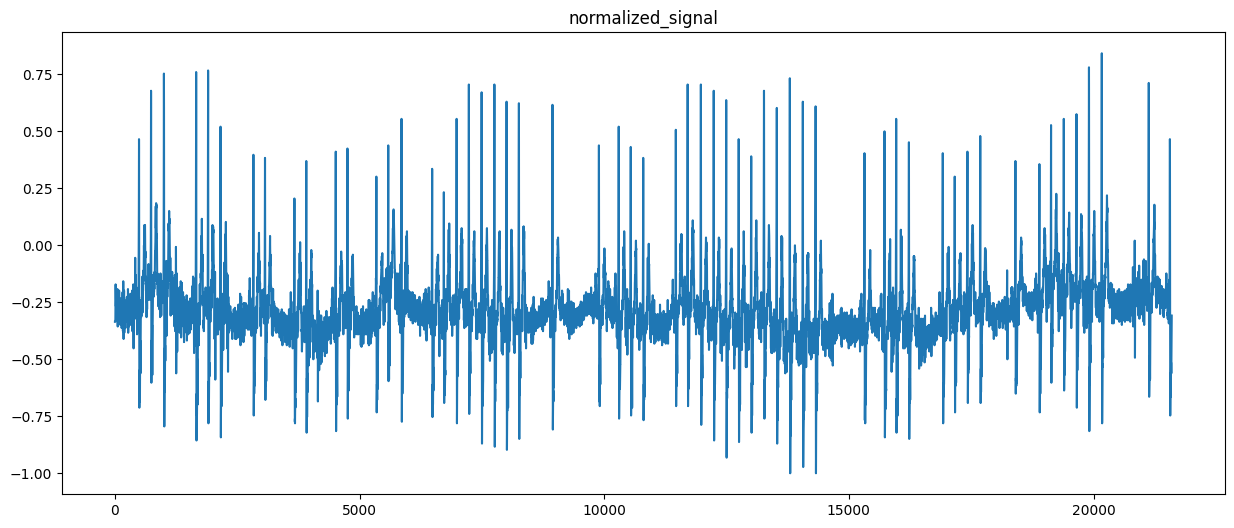

In [97]:
def amplitude_normalization(signal):
    return signal / np.max(np.abs(signal))

# normalized_signal = amplitude_normalization(ecg_signal)

normalized_signal = ecg_signal / np.max(np.abs(ecg_signal))
plt.figure(figsize=(15, 6))
plt.plot(normalized_signal)
plt.title("normalized_signal")
plt.show()

Bandpass Filtering (0.5–40 Hz)

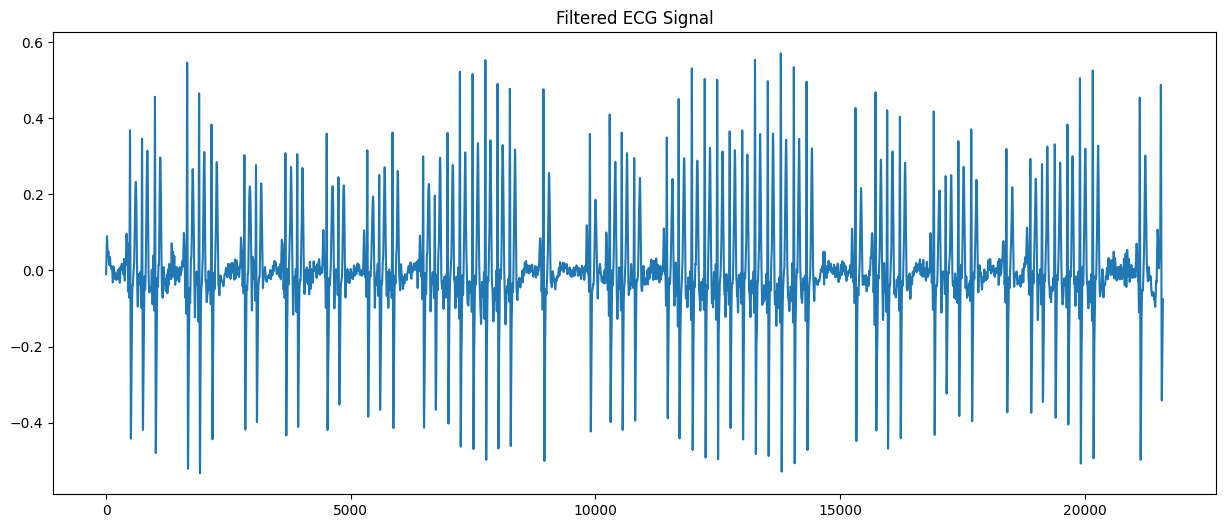

In [98]:
# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     y = filtfilt(b, a, data)
#     return y

# # filtered_signal = butter_bandpass_filter(normalized_signal, 0.5, 40, fs)
# filtered_signal = butter_bandpass_filter(normalized_signal, 1, 15, fs)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

filtered_signal = butter_bandpass_filter(normalized_signal, 1, 15, fs)

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal)
plt.title("Filtered ECG Signal")
plt.show()

QRS Complex Detection (Pan-Tompkins)

Detected 142 R-peaks


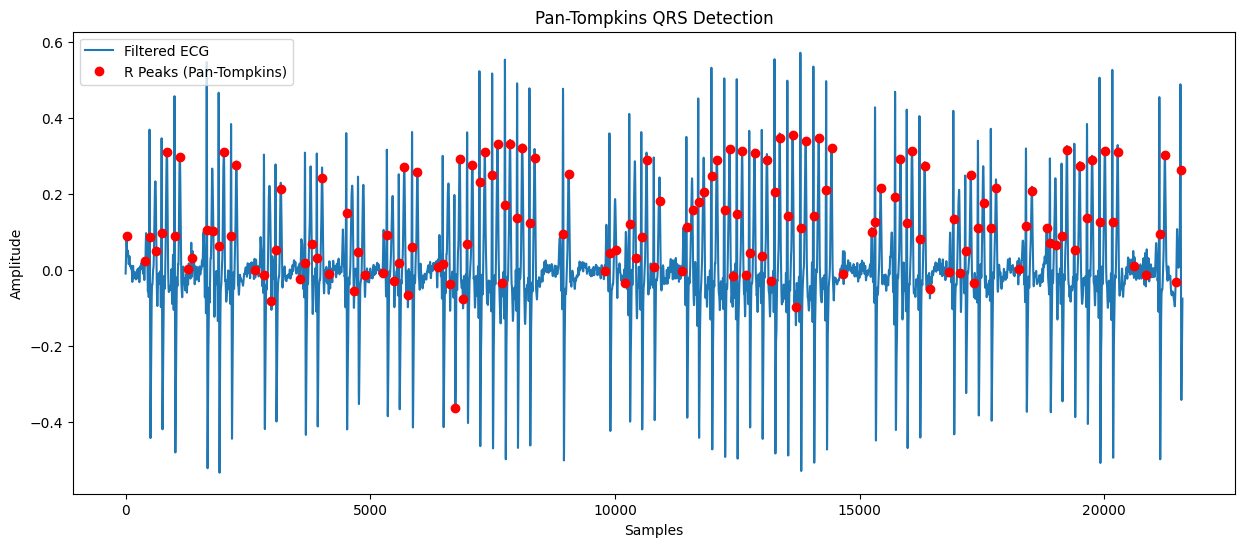

In [99]:
# def pan_tompkins_qrs_detection(signal, fs, threshold_ratio=0.2):
#     # 1. Differentiation
#     diff_signal = np.diff(signal, prepend=signal[0])
#     # 2. Squaring
#     squared_signal = diff_signal ** 2
#     # 3. Moving window integration
#     window_size = int(0.11 * fs)
#     integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')
#     # 4. Thresholding
#     # threshold = threshold_ratio * np.max(integrated_signal)
#     threshold = threshold_ratio * np.median(integrated_signal)
#     qrs_peaks, _ = find_peaks(integrated_signal, height=threshold, distance=int(0.2*fs))
#     return qrs_peaks, integrated_signal

# # Use the function and plot results
# qrs_peaks, integrated_signal = pan_tompkins_qrs_detection(filtered_signal, fs)

# print(f"Detected {len(qrs_peaks)} QRS peaks (Pan-Tompkins)")

def pan_tompkins_qrs_detection(signal, fs, threshold_ratio=0.6):
    diff_signal = np.diff(signal, prepend=signal[0])
    squared = diff_signal ** 2
    window = int(0.11 * fs)
    integrated = np.convolve(squared, np.ones(window)/window, 'same')
    threshold = threshold_ratio * np.median(integrated)
    peaks, _ = find_peaks(integrated, height=threshold, distance=int(0.2*fs))
    return peaks

r_peaks = pan_tompkins_qrs_detection(filtered_signal, fs)
print(f"Detected {len(r_peaks)} R-peaks")

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG')
plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks (Pan-Tompkins)')
plt.title("Pan-Tompkins QRS Detection")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# # Optional: Plot the integrated signal and threshold
# plt.figure(figsize=(15, 4))
# plt.plot(integrated_signal, label='Integrated Signal')
# plt.axhline(y=0.5 * np.max(integrated_signal), color='r', linestyle='--', label='Threshold')
# plt.title("Integrated Signal (Pan-Tompkins)")
# plt.legend()
# plt.show()

 Feature Extraction

In [100]:
def detect_r_peaks(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs*0.6)
    return peaks

# r_peaks = detect_r_peaks(filtered_signal, fs)
# r_peaks = qrs_peaks  # Rename for clarity
# print(f"Detected {len(r_peaks)} R-peaks (Pan-Tompkins)")
# print(f"Detected {len(r_peaks)} R-peaks")
# plt.figure(figsize=(15, 6))
# plt.plot(filtered_signal)
# plt.plot(r_peaks, filtered_signal[r_peaks], 'ro')
# plt.title("Filtered ECG Signal with R-peaks")
# plt.show()


Detect Q, S, P, T Peaks

Detected 142 Q-peaks at locations: [    2   382   478   628   724   828   988  1090  1253  1330  1647  1792
  1891  1991  2144  2248  2625  2817  2974  3053  3158  3568  3655  3802
  3897  4002  4151  4497  4658  4738  4882  5249  5328  5482  5572  5676
  5769  5843  5947  6374  6470  6623  6740  6811  6896  6969  7070  7219
  7322  7479  7584  7667  7741  7841  7990  8090  8242  8345  8929  9038
  9786  9878 10026 10200 10282 10428 10528 10633 10784 10901 11361 11449
 11586 11691 11825 11960 12065 12224 12327 12406 12479 12582 12663 12735
 12837 12991 13093 13174 13251 13352 13513 13615 13699 13780 13883 14045
 14147 14305 14409 14669 15233 15305 15412 15714 15818 15953 16055 16213
 16316 16439 16812 16905 17058 17149 17256 17339 17408 17540 17671 17777
 18243 18389 18507 18807 18879 19022 19117 19222 19379 19484 19637 19739
 19893 19999 20155 20261 20583 20828 21116 21221 21450 21546]
Detected 142 S-peaks at locations: [   36.   402.   508.   646.   754.   863.  1017.  1125.  1276.  

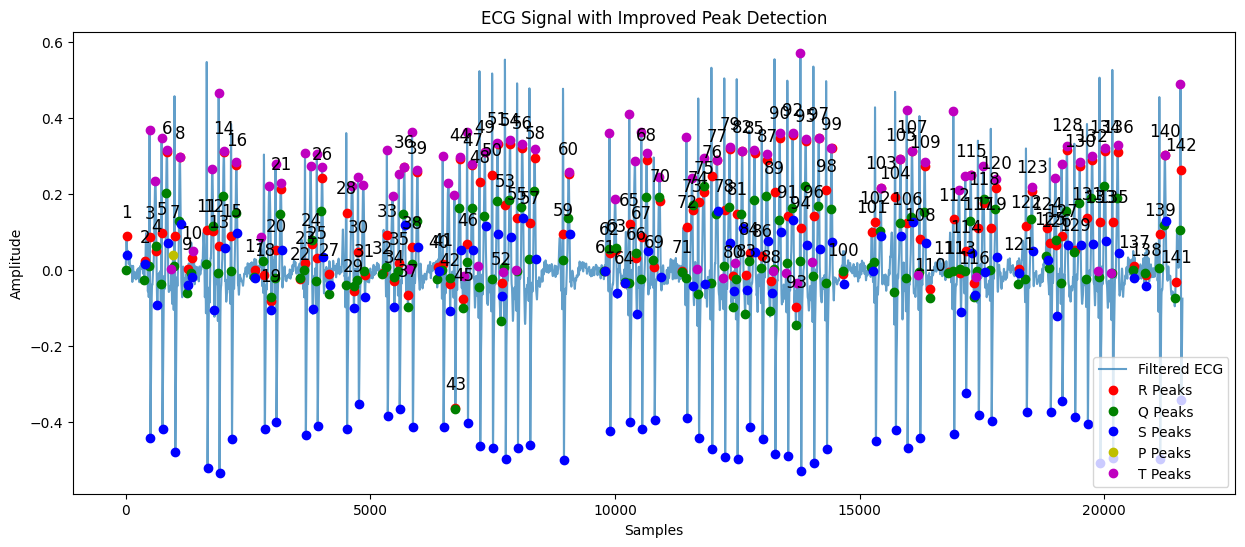

In [101]:
# def detect_qs_peaks(signal, r_peaks, fs):
#     q_peaks, s_peaks = [], []
#     search_window = int(0.05 * fs)  # 50 ms before/after R-peak
    
#     for r in r_peaks:
#         # Q-peak: Search 50 ms before R-peak
#         q_start = max(0, r - search_window)
#         q_window = signal[q_start:r]
#         if len(q_window) > 0:
#             q_peak = np.argmin(q_window) + q_start
#             q_peaks.append(q_peak)
#         else:
#             q_peaks.append(np.nan)
        
#         # S-peak: Search 50 ms after R-peak
#         s_end = min(len(signal), r + search_window)
#         s_window = signal[r:s_end]
#         if len(s_window) > 0:
#             s_peak = np.argmin(s_window) + r
#             s_peaks.append(s_peak)
#         else:
#             s_peaks.append(np.nan)
    
#     return np.array(q_peaks), np.array(s_peaks)

# def detect_pt_peaks(signal, r_peaks, fs):
#     p_peaks, t_peaks = [], []
#     r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)
    
#     for i, r in enumerate(r_peaks):
#         # P-wave detection (positive deflection only)
#         p_start = max(0, r - int(0.3 * fs))  # 300ms before R-peak
#         p_window = signal[p_start:r]
#         p_peak, _ = find_peaks(p_window, prominence=0.15 * np.max(signal))  # Increased prominence
#         # Lower prominence threshold for P-waves (from 0.15 to 0.05)
#         # p_peak, _ = find_peaks(p_window, prominence=0.05 * np.max(signal))  # Adjusted
        
#         if len(p_peak) > 0:
#             p_peaks.append(p_peak[0] + p_start)
#         else:
#             p_peaks.append(np.nan)
        
#         # T-wave: Search after R-peak
#         # t_start = r + int(0.2 * fs) 
#         t_start = r + int(0.2 * fs)  
#         t_end = min(len(signal), r + int(0.4 * fs))
#         # t_end = min(len(signal), r + int(0.5 * fs))
#         t_window = signal[t_start:t_end]
#         t_peak, _ = find_peaks(t_window, prominence=0.01 * np.max(signal))
#         if len(t_peak) > 0:
#             t_peaks.append(t_peak[0] + t_start)
#         else:
#             t_peaks.append(np.nan)
    
#     return np.array(p_peaks), np.array(t_peaks)



# q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks,fs)
# p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)

def detect_qs_peaks(signal, r_peaks, fs):
    q_peaks, s_peaks = [], []
    search_window = int(0.05 * fs)  # 50ms
    
    for r in r_peaks:
        # Q detection
        q_start = max(0, r - search_window)
        q_val = np.argmin(signal[q_start:r]) + q_start
        q_peaks.append(q_val if q_val < r else np.nan)
        
        # S detection
        s_end = min(len(signal), r + search_window)
        s_val = np.argmin(signal[r:s_end]) + r
        s_peaks.append(s_val if s_val > r else np.nan)
    
    return np.array(q_peaks), np.array(s_peaks)

def detect_pt_peaks(signal, r_peaks, fs):
    p_peaks, t_peaks = [], []
    for r in r_peaks:
        # P detection (200-50ms before R)
        p_start = max(0, r - int(0.2*fs))
        p_window = signal[p_start:max(0,r-int(0.05*fs))]
        p = find_peaks(p_window, prominence=0.1)[0]
        p_peaks.append(p[0]+p_start if len(p)>0 else np.nan)
        
        # T detection (200-400ms after R)
        t_start = r + int(0.2*fs)
        t_end = min(len(signal), r + int(0.4*fs))
        t_window = signal[t_start:t_end]
        t = find_peaks(t_window, prominence=0.05)[0]
        t_peaks.append(t[0]+t_start if len(t)>0 else np.nan)
    
    return np.array(p_peaks), np.array(t_peaks)

q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks, fs)
p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)

valid_p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
valid_r_peaks = r_peaks[~np.isnan(r_peaks)].astype(int)

# Print the detected peak counts and locations
print(f"Detected {len(q_peaks)} Q-peaks at locations: {q_peaks}")
print(f"Detected {len(s_peaks)} S-peaks at locations: {s_peaks}")
print(f"Detected {len(valid_p_peaks)} P-peaks at locations: {valid_p_peaks}")
print(f"Detected {len(t_peaks)} T-peaks at locations: {t_peaks}")

plt.figure(figsize=(15, 6))
plt.plot(filtered_signal, label='Filtered ECG', alpha=0.7)

# annotate r-peaks with numbers
for i, r in enumerate(valid_r_peaks):
    plt.text(r, filtered_signal[r] + 0.05, str(i+1), color='black', fontsize=12, ha='center')  # Annotate with peak number

plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')

plt.title('ECG Signal with Improved Peak Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Calculate Dynamic Features

In [102]:
# rr_intervals = np.diff(r_peaks) / fs  # In seconds
# heart_rate = 60 / np.mean(rr_intervals)
# hrv = (np.max(rr_intervals) - np.min(rr_intervals)) * 100
rr = np.diff(r_peaks)/fs
hr = 60 / np.mean(rr)
hrv = (np.max(rr) - np.min(rr)) * 1000  # in ms
print(f"Heart rate: {hr:.2f} bpm")
print(f"HRV: {hrv:.2f} ms")

Heart rate: 141.37 bpm
HRV: 1877.78 ms


R/P Ratio

In [103]:
# # Ensure both arrays have the same length
# min_length = min(len(valid_r_peaks), len(valid_p_peaks))
# valid_r_peaks = valid_r_peaks[:min_length]
# valid_p_peaks = valid_p_peaks[:min_length]

# # Extract amplitudes
# r_amplitudes = filtered_signal[valid_r_peaks]
# p_amplitudes = filtered_signal[valid_p_peaks]

# # Avoid division by zero
# safe_p_amplitudes = np.where(p_amplitudes == 0, np.nan, p_amplitudes)
# r_to_p_ratio = np.nanmean(r_amplitudes / safe_p_amplitudes)  # Ignore NaN values

# print(f"R-to-P amplitude ratio: {r_to_p_ratio:.2f}")

# print(f"Mean RR Interval: {np.mean(rr_intervals):.2f}s, HR: {heart_rate:.2f} bpm")
# # print(f"RR Standard Deviation: {rr_std:.2f}s, P-Peak Count: {len(valid_p_peaks)}")

# QRS durations
valid_q = q_peaks[~np.isnan(q_peaks)].astype(int)
valid_s = s_peaks[~np.isnan(s_peaks)].astype(int)
qrs_durations = (valid_s[:len(valid_q)] - valid_q)/fs * 1000
mean_qrs = np.mean(qrs_durations)

# P-wave presence
valid_p = p_peaks[~np.isnan(p_peaks)]
p_ratio = len(valid_p)/len(r_peaks)

# R/P amplitude ratio
r_amps = filtered_signal[r_peaks.astype(int)]
p_amps = filtered_signal[valid_p.astype(int)[:len(r_peaks)]]
r_p_ratio = np.nanmean(r_amps[:len(p_amps)] / np.nanmean(p_amps))

ValueError: operands could not be broadcast together with shapes (132,) (142,) 

Rule-Based Classification

In [ ]:
# classification = []

# # Calculate QRS duration (ensure valid Q/S peaks)
# valid_q = q_peaks[~np.isnan(q_peaks)].astype(int)
# valid_s = s_peaks[~np.isnan(s_peaks)].astype(int)
# min_length = min(len(valid_q), len(valid_s))
# qrs_durations = (valid_s[:min_length] - valid_q[:min_length]) / fs * 1000  # milliseconds
# wide_qrs = np.mean(qrs_durations) > 120  # VTach threshold

# # Check for P-wave absence
# p_peak_ratio = len(valid_p_peaks) / len(r_peaks) if len(r_peaks) > 0 else 0
# p_absent = p_peak_ratio < 0.3  # <30% P-waves detected

# # Ventricular Tachycardia Check (priority)
# if wide_qrs and p_absent and (heart_rate > 100):
#     classification.append("Ventricular Tachycardia (Suspected)")

# # Atrial Fibrillation Check
# rr_std = np.std(rr_intervals)
# afib_condition = (rr_std > 0.15) and (p_peak_ratio < 0.4) and (r_to_p_ratio > 5)

# if afib_condition and not wide_qrs:
#     classification.append("Atrial Fibrillation (Suspected)")

# # # Basic heart rate classification
# # elif heart_rate < 60:
# #     classification.append("Bradycardia")
# # elif heart_rate > 100:
# #     classification.append("Tachycardia")

# # Default to Normal
# if not classification:
#     classification.append("Normal - Healthy")

# print(f"Mean RR Interval: {np.mean(rr_intervals):.2f}s, HR: {heart_rate:.2f} bpm")
# print(f"QRS Duration: {np.mean(qrs_durations):.1f}ms, RR STD: {rr_std:.2f}s")
# print(f"P-wave Ratio: {p_peak_ratio:.2f}, R/P Ratio: {r_to_p_ratio:.1f}")
# print("Classification Results:", ", ".join(classification))

classification = []
rr_std = np.std(rr)

# Ventricular Tachycardia Criteria
vtach = (mean_qrs > 120) and (p_ratio < 0.3) and (hr > 100)
if vtach:
    classification.append("Ventricular Tachycardia (Suspected)")

# Atrial Fibrillation Criteria
afib = (rr_std > 0.15) and (p_ratio < 0.4) and (r_p_ratio > 5) and (not vtach)
if afib:
    classification.append("Atrial Fibrillation (Suspected)")

# Basic rhythm classification
if not classification:
    if hr < 60: classification.append("Bradycardia")
    elif hr > 100: classification.append("Tachycardia")
    else: classification.append("Normal Sinus Rhythm")

# =============================================
# Reporting
# =============================================
print(f"\nDiagnostic Summary:")
print(f"HR: {hr:.1f} bpm | QRS: {mean_qrs:.1f}ms | RR STD: {rr_std:.2f}s")
print(f"P-wave Ratio: {p_ratio:.2f} | R/P Ratio: {r_p_ratio:.1f}:1")
print("Classification:", " | ".join(classification))

In [ ]:
# plt.figure(figsize=(15, 6))
# plt.plot(filtered_signal, label='Filtered ECG')
# plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
# plt.plot(q_peaks[~np.isnan(q_peaks)].astype(int), filtered_signal[q_peaks[~np.isnan(q_peaks)].astype(int)], 'go', label='Q Peaks')
# plt.plot(s_peaks[~np.isnan(s_peaks)].astype(int), filtered_signal[s_peaks[~np.isnan(s_peaks)].astype(int)], 'bo', label='S Peaks')
# plt.plot(p_peaks[~np.isnan(p_peaks)].astype(int), filtered_signal[p_peaks[~np.isnan(p_peaks)].astype(int)], 'yo', label='P Peaks')
# plt.plot(t_peaks[~np.isnan(t_peaks)].astype(int), filtered_signal[t_peaks[~np.isnan(t_peaks)].astype(int)], 'mo', label='T Peaks')
# plt.title('ECG Signal with Detected Peaks')
# plt.xlabel('Samples')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()

# Reporting
# =============================================
print(f"\nDiagnostic Summary:")
print(f"HR: {hr:.1f} bpm | QRS: {mean_qrs:.1f}ms | RR STD: {rr_std:.2f}s")
print(f"P-wave Ratio: {p_ratio:.2f} | R/P Ratio: {r_p_ratio:.1f}:1")
print("Classification:", " | ".join(classification))

# =============================================
# Visualization
# =============================================
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Raw ECG
ax[0].plot(ecg_signal)
ax[0].set_title("Raw ECG Signal")

# Processed ECG with Peaks
ax[1].plot(filtered_signal, label='Filtered')
ax[1].scatter(r_peaks, filtered_signal[r_peaks], c='r', label='R-peaks')
ax[1].scatter(q_peaks, filtered_signal[q_peaks.astype(int)], c='g', label='Q-peaks')
ax[1].scatter(s_peaks, filtered_signal[s_peaks.astype(int)], c='b', label='S-peaks')
ax[1].scatter(p_peaks, filtered_signal[p_peaks.astype(int)], c='y', label='P-peaks')
ax[1].scatter(t_peaks, filtered_signal[t_peaks.astype(int)], c='m', label='T-peaks')
ax[1].set_title("Processed ECG with Feature Points")
ax[1].legend()

# Heart Rate Trend
ax[2].plot(r_peaks[1:]/fs, 60/rr, 'b-o')
ax[2].set_title("Instantaneous Heart Rate")
ax[2].set_ylabel("BPM")
ax[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
# plt.plot(r_peaks[1:]/fs, 60/rr_intervals, 'b-')
plt.plot(r_peaks[1:]/fs, 60/rr, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.legend(['Heart Rate'])
plt.title('Heart Rate Variability (HRV)')
plt.grid(True)
plt.show()